In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import re
import json
import csv
import threading
import os
import pickle

import datetime

import yfinance as yf
import yahoofinancials


In [2]:
def min_max_date(df):
    """
    Get the min and max date of the ticker being mentioned in our WSB dataset
    """
    min_date = df.sort_values('datetime').iloc[0]["datetime"].date()
    max_date = df.sort_values('datetime', ascending= False).iloc[0]["datetime"].date()
    return(min_date, max_date)

def explode_action_column(df):
    """
    Explodes columns of
    dict(puts: [., ., .,]
         calls: [., ., .,]
         sell: [., ., .,]
         buy: [., ., .,])
         
    into four columns ...
    |puts|calls|sell|buy|
    """
    return pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

def date_from_datetime(df):
    """
    Make datetime to date
    """
    df_copy = df.copy()
    df_copy["Date"] = df_copy["datetime"].dt.date
    return df_copy

def flatten_filter(df, ticker, filter = True):
    """
    Explodes the column of lists of tickers into multiple rows and then filter for ticker
    """
    df_copy = df.copy()
    df_flatten = df_copy.explode('tickers')
    if filter:
        df_flatten = df_flatten[df_flatten['tickers'] == ticker]
    else:
        return df_flatten
    return df_flatten

def indicator_actions(df, ticker):
    """
    Make indicator variables for ticker instead of list of tickers
    """
    df_copy = df.copy()
    df_copy = explode_action_column(df_copy)
    df_copy["puts"] = ((df_copy["puts"].apply(len) != 0) & 
                      (df_copy["puts"].astype('str').str.contains(ticker))).astype(int)
    df_copy["calls"] = ((df_copy["calls"].apply(len) != 0) & 
                       (df_copy["calls"].astype('str').str.contains(ticker))).astype(int)
    df_copy["buy"] = ((df_copy["buy"].apply(len) != 0) & 
                     (df_copy["buy"].astype('str').str.contains(ticker))).astype(int)
    df_copy["sell"] = ((df_copy["sell"].apply(len) != 0) & 
                      (df_copy["sell"].astype('str').str.contains(ticker))).astype(int)
    return df_copy

def plot_actions(df, ticker, min_date, max_date, hide_score = True):
    """
    Plot the aggregate sum of sell, buy, calls ,puts for each day within range for a specific ticker
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    if hide_score:
        agg_sell = df_copy[['Date','sell','buy','calls','puts']].groupby('Date').agg('sum')
    else:
        agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')


    # Filter for range specified
    mask = (agg_sell.index > pd.to_datetime("2018-01-01").date()) & (agg_sell.index <= max_date)

    agg_sell.loc[mask].plot(figsize=(12, 10), linewidth=2.5)
    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Movement Mentions", labelpad=15)
    plt.title("Movement mentions for {0} from {1} to {2}".format(ticker, str(min_date), str(max_date)), y=1.02, fontsize=22);

def plot_stock_vs_wsb(df,ticker, min_date, max_date, stock_col, action_col):
    """
    Plot the a specfic financial action mention in WSB comments vs historical data
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')
    
    
    # Get the minimum date of that ticker mentioned on our WSB comment
    MIN_DATE, MAX_DATE = min_max_date(df)

    # Pull the data from yahoo finance api
    stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)
    
    # Filter for range specified
    mask = (stock_data.index > np.datetime64(str(min_date))) & (stock_data.index <= np.datetime64(max_date))

    plot_multi(stock_data.loc[mask].join(other = agg_sell)[[stock_col,action_col]], figsize=(10,5))

    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Daily {0} mentions".format(action_col), labelpad=15)
    plt.title("Daily {1} mentions vs {2} from {3} to {4} for {0}".format(ticker, action_col, stock_col, str(min_date), str(max_date)), y=1.02, fontsize=22);

In [3]:
data = pickle.load(open("wsb.pkl", "rb"))


In [4]:
test = flatten_filter(data, "None", filter = False)


In [5]:
test["tickers"].value_counts()


MU      33450
AMD     32526
TSLA    12079
AAPL    11760
NVDA    11087
        ...  
CATB        1
SPRO        1
DGRS        1
TYHT        1
SURF        1
Name: tickers, Length: 1947, dtype: int64

In [6]:
ticker = "TSLA"
tesla_df = date_from_datetime(flatten_filter(data, ticker))


In [7]:
    # Get the minimum date of that ticker mentioned on our WSB comment
MIN_DATE, MAX_DATE = min_max_date(tesla_df)

    # Pull the data from yahoo finance api
stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)


[*********************100%***********************]  1 of 1 completed


In [8]:
tesla_sent = indicator_actions(tesla_df, ticker)


In [9]:
agg_sell = tesla_sent[['Date','sell','buy','calls','puts','score']].groupby('Date').agg('sum')

df = agg_sell.join(stock_data).dropna().reset_index()


In [10]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Date,sell,buy,calls,puts,score,Open,High,Low,Close,Adj Close,Volume
0,2013-04-09,0,1,0,0,1,41.799999,41.830002,40.330002,40.500000,40.500000,1696100.0
1,2013-05-08,0,1,0,0,2,57.500000,58.200001,55.709999,55.790001,55.790001,6769900.0
2,2013-05-09,1,0,0,0,1,70.120003,75.769997,63.689999,69.400002,69.400002,28605000.0
3,2013-05-10,0,2,0,0,3,69.650002,81.000000,69.250000,76.760002,76.760002,25082600.0
4,2013-05-14,1,2,0,0,3,94.220001,97.120003,81.150002,83.239998,83.239998,37163900.0


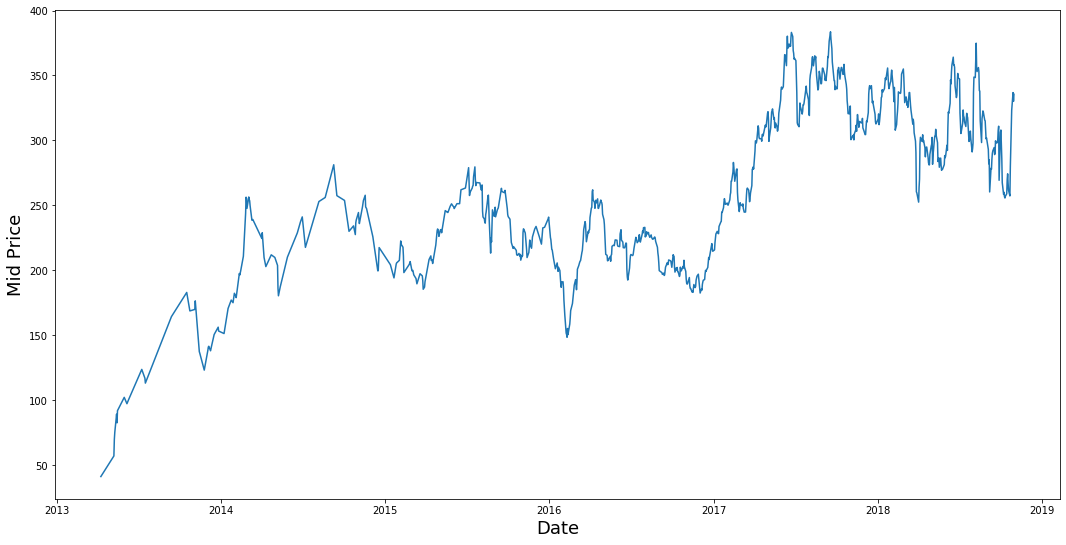

In [11]:
plt.figure(figsize = (18,9))
plt.plot(df["Date"],(df['Low']+df['High'])/2.0)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [12]:
# First calculate the mid prices from the highest and lowest
high_prices = np.matrix(df.loc[:,'High'])
low_prices = np.matrix(df.loc[:,'Low'])
mid_prices = (high_prices+low_prices)/2.0


In [13]:
train_data = mid_prices[0,:800]
test_data = mid_prices[0,800:]


In [14]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [15]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 10
for di in range(0,100,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])



In [16]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)



In [17]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
test_train_data = train_data.copy()
EMA = 0.0
gamma = 0.1
for ti in range(800):
    EMA = gamma*train_data[0,ti] + (1-gamma)*EMA
    test_train_data[0,ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([test_train_data.T,test_data.reshape(104, 1)],axis=0)

In [18]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[0,pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[0,pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01044


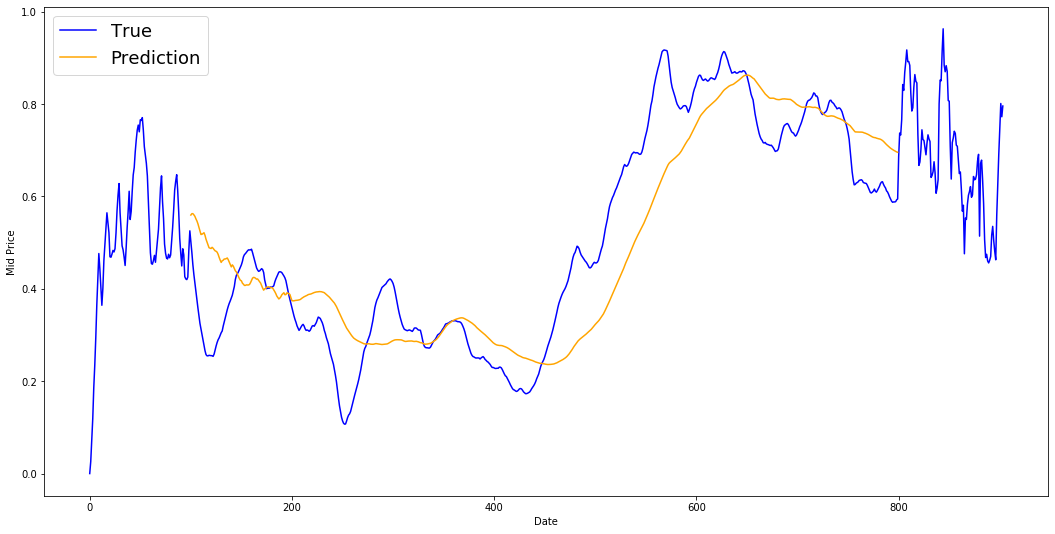

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [20]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[0,pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[0,pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))



MSE error for EMA averaging: 0.00650


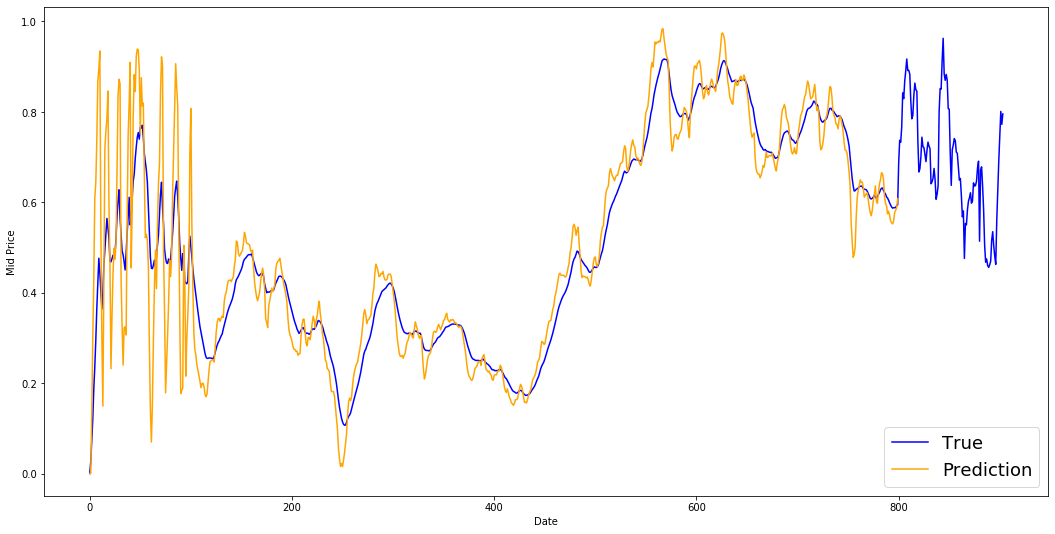

In [21]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()



## LSTM

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


Using TensorFlow backend.


In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [24]:
# First calculate the mid prices from the highest and lowest
high_prices = df["High"]
low_prices = df["Low"]
df["mid_prices"] = (high_prices+low_prices)/2.0


In [65]:
def scale_df(values):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[5,6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    values = reframed.values
    limit = 800
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y

def reshape_features(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X

def plot_history(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var6(t)
1   0.000000   0.007194        0.0        0.0   0.002074  0.046342
2   0.000000   0.007194        0.0        0.0   0.002333  0.083634
3   0.076923   0.000000        0.0        0.0   0.002074  0.099383
4   0.000000   0.014388        0.0        0.0   0.002593  0.140280
5   0.076923   0.014388        0.0        0.0   0.002593  0.120897
(800, 1, 5) (800,) (103, 1, 5) (103,)


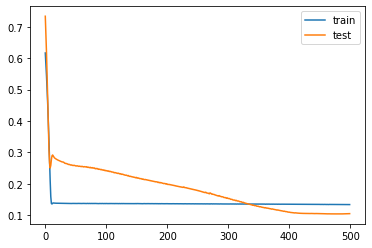

Test RMSE: 31.672


In [80]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['sell','buy','calls','puts','score','mid_prices']]
values = main_df.values


# ensure all data is float
values = values.astype('float32')

# normalize features
scaled = scale_df(values)
#frame as supervised learning
reframed = reframe_df(scaled)

print(reframed.head())

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,4]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,4]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

Text(0, 0.5, 'Stock MidPrices')

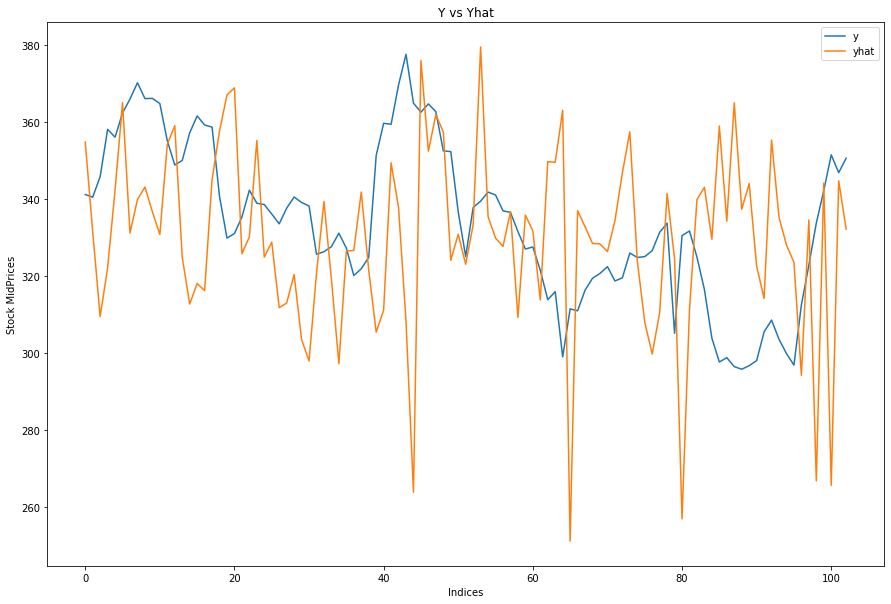

In [81]:
pd.DataFrame(data = {'y':inv_y, 'yhat': inv_yhat}).plot(figsize=(15,10))
plt.title("Y vs Yhat")
plt.xlabel("Indices")
plt.ylabel("Stock MidPrices")

In [82]:
train_y_ = train_y.reshape((len(train_y), 1))
inv_y_ = concatenate((np.zeros(shape = (800,6))[:, 1:],train_y_), axis=1)
inv_y_ = scaler.inverse_transform(inv_y_)
inv_y_ = inv_y_[:,5]



In [83]:
test = np.zeros(concatenate((inv_y_,inv_y), axis = 0).shape)
test = np.full_like(test, np.nan,dtype=np.double)

In [84]:
test[-103:] = inv_yhat

Text(0, 0.5, 'Stock MidPrices')

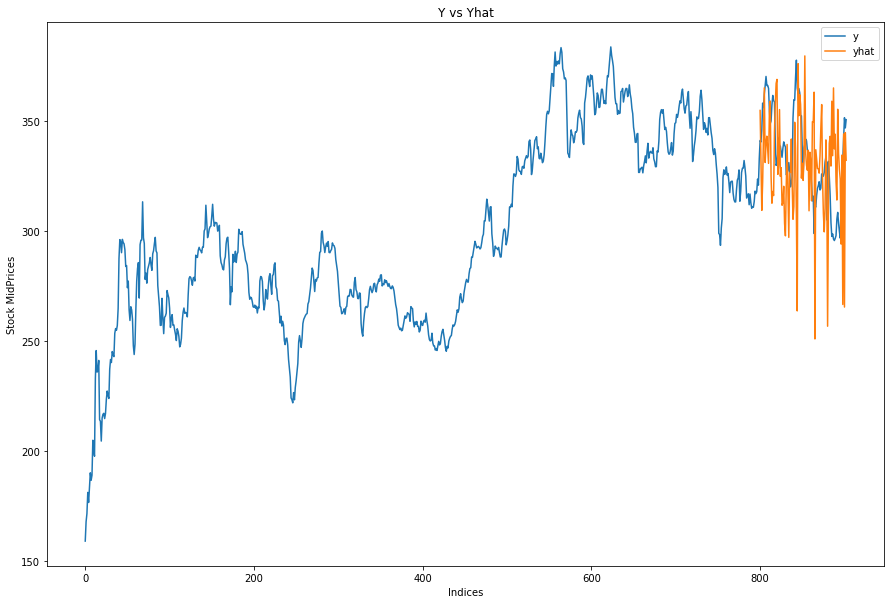

In [85]:
pd.DataFrame(data = {'y':concatenate((inv_y_,inv_y), axis = 0), 'yhat': test}).plot(figsize=(15,10))
plt.title("Y vs Yhat")
plt.xlabel("Indices")
plt.ylabel("Stock MidPrices")

In [ ]:
def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

   var1(t-1)   var1(t)
1   0.000000  0.046342
2   0.046342  0.083634
3   0.083634  0.099383
4   0.099383  0.140280
5   0.140280  0.120897
(800, 1, 1) (800,) (103, 1, 1) (103,)
Train on 800 samples, validate on 103 samples
Epoch 1/100
 - 0s - loss: 0.6078 - val_loss: 0.7312
Epoch 2/100
 - 0s - loss: 0.5575 - val_loss: 0.6744
Epoch 3/100
 - 0s - loss: 0.5051 - val_loss: 0.6153
Epoch 4/100
 - 0s - loss: 0.4501 - val_loss: 0.5525
Epoch 5/100
 - 0s - loss: 0.3913 - val_loss: 0.4842
Epoch 6/100
 - 0s - loss: 0.3277 - val_loss: 0.4096
Epoch 7/100
 - 0s - loss: 0.2582 - val_loss: 0.3270
Epoch 8/100
 - 0s - loss: 0.1833 - val_loss: 0.2366
Epoch 9/100
 - 0s - loss: 0.1125 - val_loss: 0.1490
Epoch 10/100
 - 0s - loss: 0.0838 - val_loss: 0.0933
Epoch 11/100
 - 0s - loss: 0.0864 - val_loss: 0.0760
Epoch 12/100
 - 0s - loss: 0.0896 - val_loss: 0.0731
Epoch 13/100
 - 0s - loss: 0.0893 - val_loss: 0.0745
Epoch 14/100
 - 0s - loss: 0.0877 - val_loss: 0.0764
Epoch 15/100
 - 0s - loss: 0.0858 - val_loss:

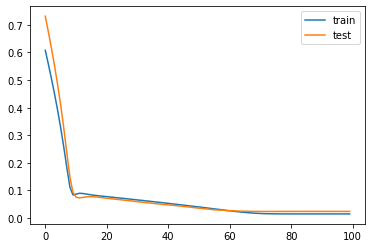

Test RMSE: 8.025


In [64]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['mid_prices']]
values = main_df.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaled = scale_df(values)
#frame as supervised learning
#reframed = reframe_df(scaled)
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

In [42]:
test_X, test_y

(array([[0.7845081 ],
        [0.8194356 ],
        [0.8165896 ],
        [0.83925676],
        [0.8915242 ],
        [0.8828106 ],
        [0.9095938 ],
        [0.92502165],
        [0.9429889 ],
        [0.92550325],
        [0.9256929 ],
        [0.92000055],
        [0.8787967 ],
        [0.85211563],
        [0.857049  ],
        [0.8876127 ],
        [0.9063536 ],
        [0.89634085],
        [0.8939471 ],
        [0.81739235],
        [0.7713134 ],
        [0.7763636 ],
        [0.7945354 ],
        [0.82425237],
        [0.8098463 ],
        [0.80837214],
        [0.7979069 ],
        [0.78707695],
        [0.8043437 ],
        [0.8167647 ],
        [0.8106345 ],
        [0.80683947],
        [0.7534336 ],
        [0.7562214 ],
        [0.7618408 ],
        [0.7767577 ],
        [0.76024985],
        [0.7298906 ],
        [0.7374221 ],
        [0.74998903],
        [0.86259544],
        [0.89818   ],
        [0.8971145 ],
        [0.94062436],
        [0.97441363],
        [0